In [1]:
# !kaggle competitions download -c tensorflow-speech-recognition-challenge

In [2]:
# import zipfile

# with zipfile.ZipFile('tensorflow-speech-recognition-challenge.zip', 'r') as f:
#     f.extractall('')

In [3]:
# !pip install librosa
# !sudo apt-get install libsndfile1

In [4]:
import pathlib
import os
import glob
import tqdm

import librosa # audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile # audio processing
import warnings
warnings.filterwarnings('ignore')

In [5]:
# !rm -rf speech/train

In [6]:
# os.system( '7z x speech/train.7z -ospeech/')
# os.system( '7z x speech/test.7z -ospeech/' )

In [7]:
ROOT_PATH = 'speech'
TRAIN_PATH = 'speech/train/audio'
TEST_PATH = 'speech/test/audio'

Labels:  31


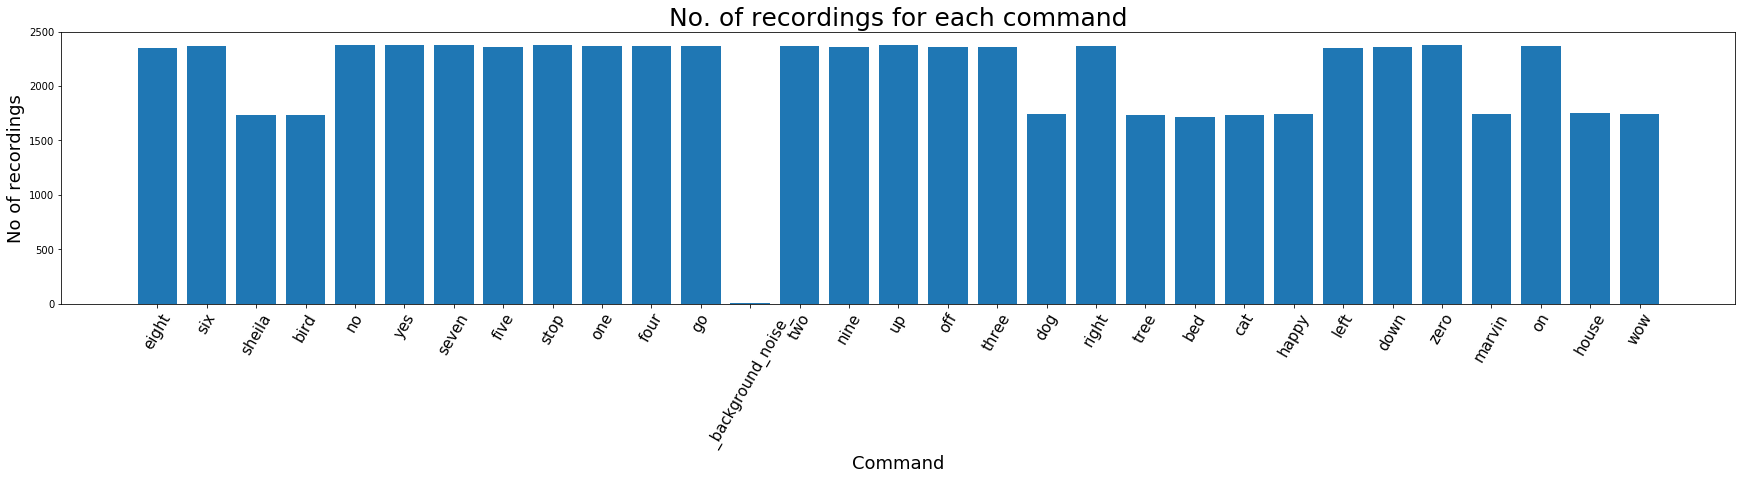

In [8]:
labels = os.listdir(TRAIN_PATH)
print('Labels: ', len(labels))
no_of_recordings = []
for label in labels:
    waves = [f for f in os.listdir(TRAIN_PATH + '/' + label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))

#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Command', fontsize=18)
plt.ylabel('No of recordings', fontsize=18)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command', fontsize=25)
plt.show()


In [9]:
import random
sample_path = os.listdir(TRAIN_PATH + '/left')
sample_path = random.choice(sample_path)
sample_path

'37dca74f_nohash_0.wav'

[0.08166504 0.10256958 0.12161255 ... 0.03338623 0.09985352 0.14935303] 16000


Text(0.5, 0, 'Time Step')

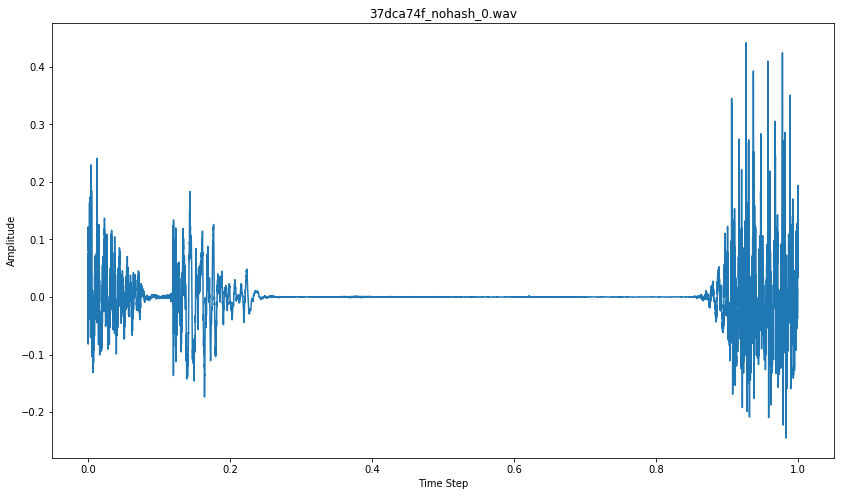

In [10]:
samples, sample_rate = librosa.load(TRAIN_PATH + '/left/' + sample_path, sr = 16000)
print(samples, sample_rate)

plt.figure(figsize=(14,8))
plt.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)
plt.title(str(sample_path))
plt.ylabel('Amplitude')
plt.xlabel('Time Step')

In [11]:
re = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(re, rate=8000)

In [12]:
r = random.randint(10000,20000)
print(r, samples.shape, re.shape)
ipd.Audio(samples, rate=r)


19374 (16000,) (8000,)


In [13]:
print(labels)

['eight', 'six', 'sheila', 'bird', 'no', 'yes', 'seven', 'five', 'stop', 'one', 'four', 'go', '_background_noise_', 'two', 'nine', 'up', 'off', 'three', 'dog', 'right', 'tree', 'bed', 'cat', 'happy', 'left', 'down', 'zero', 'marvin', 'on', 'house', 'wow']


In [15]:
labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
unknown = []
full_labels = os.listdir(TRAIN_PATH)
for label in full_labels:
    if label not in labels:
        unknown.append(label)
        
unknown.remove('_background_noise_')
print(unknown, full_labels, sep='\n')

['eight', 'six', 'sheila', 'bird', 'seven', 'five', 'one', 'four', 'two', 'nine', 'three', 'dog', 'tree', 'bed', 'cat', 'happy', 'zero', 'marvin', 'house', 'wow']
['eight', 'six', 'sheila', 'bird', 'no', 'yes', 'seven', 'five', 'stop', 'one', 'four', 'go', '_background_noise_', 'two', 'nine', 'up', 'off', 'three', 'dog', 'right', 'tree', 'bed', 'cat', 'happy', 'left', 'down', 'zero', 'marvin', 'on', 'house', 'wow']


In [17]:
from tqdm import tqdm
labels=['unknown', "yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

all_label = []
all_wave = []
old = []

for i in tqdm(range(len(labels))):
    if labels[i] == 'unknown':
        for label in unknown:
            waves = [f for f in os.listdir(TRAIN_PATH + '/' + label) if f.endswith('wav')]
            for wave in waves:
                samples, rate = librosa.load(TRAIN_PATH + '/' + label + '/'+ wave, sr=16000)
                samples = librosa.resample(samples, rate, 8000)
                if len(samples) == 8000:
                    all_wave.append(samples)
                    all_label.append('unknown')
    else:
        waves = [f for f in os.listdir(TRAIN_PATH + '/' + labels[i]) if f.endswith('wav')]
        for wave in waves:
            samples, rate = librosa.load(TRAIN_PATH + '/' + labels[i] + '/'+ wave, sr=16000)
            samples = librosa.resample(samples, rate, 8000)
            if len(samples) == 8000:
                all_wave.append(samples)
                all_label.append(labels[i])

            


100%|██████████| 11/11 [19:51<00:00, 108.35s/it][A


In [18]:
print(len(all_wave), labels)

58252 ['unknown', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']


In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(all_label)
classes = list(le.classes_)
print(len(y), y[0], classes)

58252 8 ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'unknown', 'up', 'yes']


In [20]:
from keras.utils import np_utils
y = np_utils.to_categorical(y, num_classes=len(labels))
print(y[0], type(y))

Using TensorFlow backend.


[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] <class 'numpy.ndarray'>


In [21]:
all_wave = np.array(all_wave).reshape(-1,8000,1)
all_wave.shape

(58252, 8000, 1)

In [22]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave), np.array(y), stratify=y, test_size =0.2, random_state=777, shuffle=True)

In [23]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#1st Conv1D layer
conv = Conv1D(8, 13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#2nd layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)


#3rd layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)


#4th layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)


#Flatten
conv = Flatten()(conv)

#Dense 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)


#Dense 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)


#Output
output = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs,output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8000, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2662, 8)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2662, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 884, 16)           0   

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history=model.fit(x_tr, y_tr ,epochs=30, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Train on 46601 samples, validate on 11651 samples
Epoch 1/30
46601/46601 [==============================] - 14s 304us/step - loss: 1.3909 - accuracy: 0.6341 - val_loss: 1.2312 - val_accuracy: 0.6355
Epoch 2/30
46601/46601 [==============================] - 12s 260us/step - loss: 1.0870 - accuracy: 0.6608 - val_loss: 0.8725 - val_accuracy: 0.7194
Epoch 3/30
46601/46601 [==============================] - 11s 244us/step - loss: 0.8673 - accuracy: 0.7178 - val_loss: 0.6996 - val_accuracy: 0.7747
Epoch 4/30
46601/46601 [==============================] - 11s 242us/step - loss: 0.7341 - accuracy: 0.7597 - val_loss: 0.6235 - val_accuracy: 0.7994
Epoch 5/30
46601/46601 [==============================] - 11s 243us/step - loss: 0.6603 - accuracy: 0.7829 - val_loss: 0.5777 - val_accuracy: 0.8184
Epoch 6/30
46601/46601 [==============================] - 11s 242us/step - loss: 0.6194 - accuracy: 0.7965 - val_loss: 0.6370 - val_accuracy: 0.7923
Epoch 7/30
46601/46601 [==============================] 

In [ ]:
from keras.models import load_model
model.save_weights('speech_weights.h5')
model.save('speech.h5')